In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#here it should add the cleaned_data set file
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("cleaned_dataset.csv")
X = df[['job_title_short', 'job_country']]

Shape after encoding: (67300, 171)
Shape after PCA: (67300, 3)


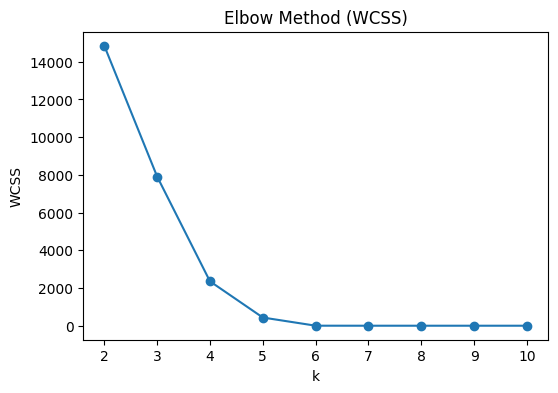

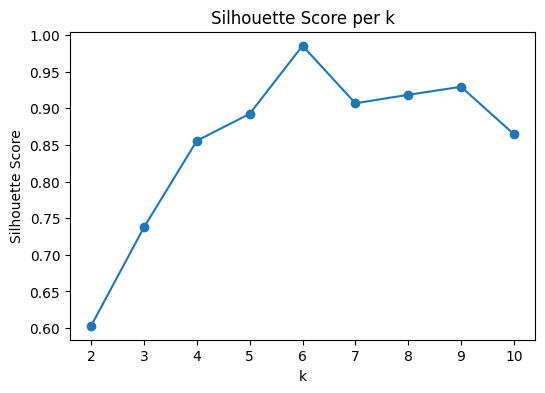

Best k = 6


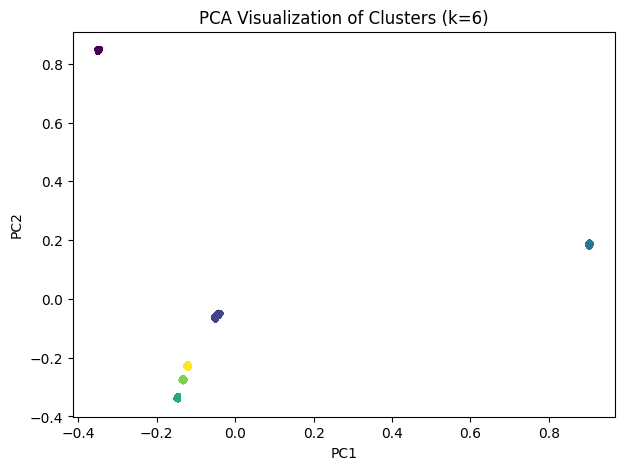

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#One Hot Encoder
enc = OneHotEncoder()
X_enc = enc.fit_transform(X).toarray()
print("Shape after encoding:", X_enc.shape)

# PCA dimenstion reduction
pca = PCA(n_components=3)   # we tried 9 and 5, 3 was the best
X_pca = pca.fit_transform(X_enc)
print("Shape after PCA:", X_pca.shape)

#elbow method
wcss = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    wcss.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method (WCSS)")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.show()

#silhouette scores
silhouette_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, labels))
plt.figure(figsize=(6,4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score per k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

#pick the best k
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print("Best k =", best_k)

#final k mean model
final_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_model.fit_predict(X_pca)
df['cluster'] = cluster_labels

#visualization
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_enc)

plt.figure(figsize=(7,5))
plt.scatter(X_vis[:,0], X_vis[:,1], c=cluster_labels, s=10)
plt.title(f"PCA Visualization of Clusters (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#save the result
df.to_csv("clustered_output.csv", index=False)
from google.colab import files
files.download("clustered_output.csv")

In [ ]:
import numpy as np
#Silhouette summary
print("Silhouette scores per k:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k = {k}: {score:.4f}")
best_sil = max(silhouette_scores)
print("\nBest k =", best_k)
print("Best Silhouette Score =", best_sil)


#WITHIN-CLUSTER SUM OF SQUARES (WCSS)
WCSS_scores = []

for k in K_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_pca)  # use PCA-reduced data
    WCSS_scores.append(kmeans_model.inertia_)  # WCSS

print("\nWCSS per k:")
for k, wcss in zip(K_range, WCSS_scores):
    print(f"  k = {k}: {wcss:.4f}")

best_wcss = WCSS_scores[list(K_range).index(best_k)]
print("\nBest k =", best_k)
print("WCSS for Best k =", best_wcss)

#bcubed precision and recall
def bcubed_precision(labels, clusters):
    precision_vals = []
    for i in range(len(labels)):
        same_cluster = np.where(clusters == clusters[i])[0]
        match = np.sum(labels[same_cluster] == labels[i])
        precision_vals.append(match / len(same_cluster))
    return np.mean(precision_vals)
def bcubed_recall(labels, clusters):
    recall_vals = []
    for i in range(len(labels)):
        same_label = np.where(labels == labels[i])[0]
        match = np.sum(clusters[same_label] == clusters[i])
        recall_vals.append(match / len(same_label))
    return np.mean(recall_vals)
labels = df['job_title_short'].astype(str).values
clusters = df['cluster'].values
bc_precision = bcubed_precision(labels, clusters)
bc_recall = bcubed_recall(labels, clusters)
print("\nBCubed Precision:", bc_precision)
print("BCubed Recall:", bc_recall)

Silhouette scores per k:
  k = 2: 0.6032
  k = 3: 0.7376
  k = 4: 0.8557
  k = 5: 0.8925
  k = 6: 0.9854
  k = 7: 0.9069
  k = 8: 0.9184
  k = 9: 0.9294
  k = 10: 0.8646

Best k = 6
Best Silhouette Score = 0.9853970383752729

WCSS per k:
  k = 2: 14847.4019
  k = 3: 7911.1856
  k = 4: 2353.9528
  k = 5: 434.7914
  k = 6: 1.6544
  k = 7: 0.3781
  k = 8: 0.2356
  k = 9: 0.2140
  k = 10: 0.1950

Best k = 6
WCSS for Best k = 1.6543794175642499

BCubed Precision: 0.63688737679443
BCubed Recall: 1.0


In [ ]:
import ast
from collections import Counter

def ensure_list_skills(sk):
    if isinstance(sk, str):
        try:
            return ast.literal_eval(sk)
        except Exception:
            return []
    elif isinstance(sk, list):
        return sk
    else:
        return []

df['job_skills_list'] = df['job_skills'].apply(ensure_list_skills)
def get_cluster_based_skills(job_title, country, top_n=10):
    X_new = pd.DataFrame(
        [[job_title, country]],
        columns=['job_title_short', 'job_country']
    )
    X_new_enc = enc.transform(X_new).toarray()
    X_new_pca = pca.transform(X_new_enc)
    cluster_id = final_model.predict(X_new_pca)[0]
    cluster_rows = df[
        (df['cluster'] == cluster_id) &
        (df['job_title_short'] == job_title) &
        (df['job_country'] == country)
    ]
    all_skills = []
    for skills in cluster_rows['job_skills_list']:
        if isinstance(skills, list):
            all_skills.extend(skills)
    if not all_skills:
        return [], cluster_id
    counts = Counter(all_skills)
    top_skills = [s for s, _ in counts.most_common(top_n)]

    return top_skills, cluster_id

def print_cluster_example(job_title, country, actual_skills, top_n=10):
    cluster_pred, cluster_id = get_cluster_based_skills(job_title, country, top_n=top_n)
    actual_set = set(actual_skills)
    overlap = actual_set & set(cluster_pred)
    match_pct = (len(overlap) / len(actual_set) * 100) if actual_set else 0
    print(f"( {job_title} {country}")
    print(f"    Actual=        {actual_skills}")
    print(f"    ClusterKMeans= {cluster_pred}   (match {match_pct:.0f}% , cluster {cluster_id})")
    print("....................................................................................................")


In [ ]:
#some preduction

print_cluster_example(
    "software engineer", "liberia",
    ['python', 'aws'],
    top_n=10
)
print_cluster_example(
    "software engineer", "tanzania",
    ['python', 'go', 'azure', 'databricks'],
    top_n=10
)
print_cluster_example(
    "cloud engineer", "peru",
    ['python', 'sql', 'pandas', 'flow'],
    top_n=10
)
print_cluster_example(
    "business analyst", "afghanistan",
    ['sas','go','oracle'],
    top_n=10
)

( software engineer liberia
    Actual=        ['python', 'aws']
    ClusterKMeans= ['python', 'aws', 'java', 'kubernetes', 'go', 'linux', 'tableau', 'gcp', 'azure', 'sql']   (match 100% , cluster 4)
....................................................................................................
( software engineer tanzania
    Actual=        ['python', 'go', 'azure', 'databricks']
    ClusterKMeans= ['python', 'java', 'git', 'go', 'azure', 'databricks', 'excel']   (match 100% , cluster 4)
....................................................................................................
( cloud engineer peru
    Actual=        ['python', 'sql', 'pandas', 'flow']
    ClusterKMeans= ['azure', 'aws', 'sql', 'python', 'kubernetes', 'java', 'docker', 'linux', 'spark', 'gcp']   (match 50% , cluster 1)
....................................................................................................
( business analyst afghanistan
    Actual=        ['sas', 'go', 'oracle']
    ClusterK

Saving clustered_output.csv to clustered_output (1).csv
Loaded clustered dataset:


,job_title_short,job_country,job_skills,cluster
0,business analyst,afghanistan,"['go', 'oracle']",5
1,business analyst,afghanistan,['sas'],5
2,business analyst,afghanistan,"['go', 'oracle']",5
3,business analyst,afghanistan,"['go', 'oracle']",5
4,business analyst,afghanistan,['sas'],5


ready: train shape = (53840, 2308)

Logistic Regression trained

SVM trained


Evaluating LogReg
Threshold 0.10  Acc=0.0960  F1w=0.4389  Prec=0.3077  Rec=0.9823
Threshold 0.15  Acc=0.1112  F1w=0.4471  Prec=0.3161  Rec=0.9761
Threshold 0.20  Acc=0.1132  F1w=0.4545  Prec=0.3254  Rec=0.9653
Threshold 0.25  Acc=0.1132  F1w=0.4656  Prec=0.3382  Rec=0.9471
Threshold 0.30  Acc=0.1134  F1w=0.4757  Prec=0.3521  Rec=0.9232
Threshold 0.35  Acc=0.1146  F1w=0.4843  Prec=0.3661  Rec=0.8996
Threshold 0.40  Acc=0.1152  F1w=0.4923  Prec=0.3817  Rec=0.8689
Threshold 0.45  Acc=0.1147  F1w=0.4991  Prec=0.3986  Rec=0.8320
Threshold 0.50  Acc=0.1143  F1w=0.5028  Prec=0.4153  Rec=0.7892
Threshold 0.55  Acc=0.1154  F1w=0.5046  Prec=0.4358  Rec=0.7362
Threshold 0.60  Acc=0.1181  F1w=0.5009  Prec=0.4594  Rec=0.6735
Threshold 0.65  Acc=0.1233  F1w=0.4905  Prec=0.4876  Rec=0.6010
Threshold 0.70  Acc=0.1320  F1w=0.4759  Prec=0.5244  Rec=0.5214
Threshold 0.75  Acc=0.1400  F1w=0.4513  Prec=0.5764  Rec=0.4312
Thresho

,model,best_threshold,subset_acc,micro_f1,macro_f1,samples_jaccard,hamming_loss,lrap,precision_weighted,recall_weighted,f1_weighted
1,SVM,0.25,0.137296,0.561050,0.442640,0.430661,0.127008,0.684947,0.479298,0.667237,0.547918
0,LogReg,0.55,0.115379,0.439617,0.386916,0.348100,0.228323,0.556702,0.435792,0.736208,0.504609


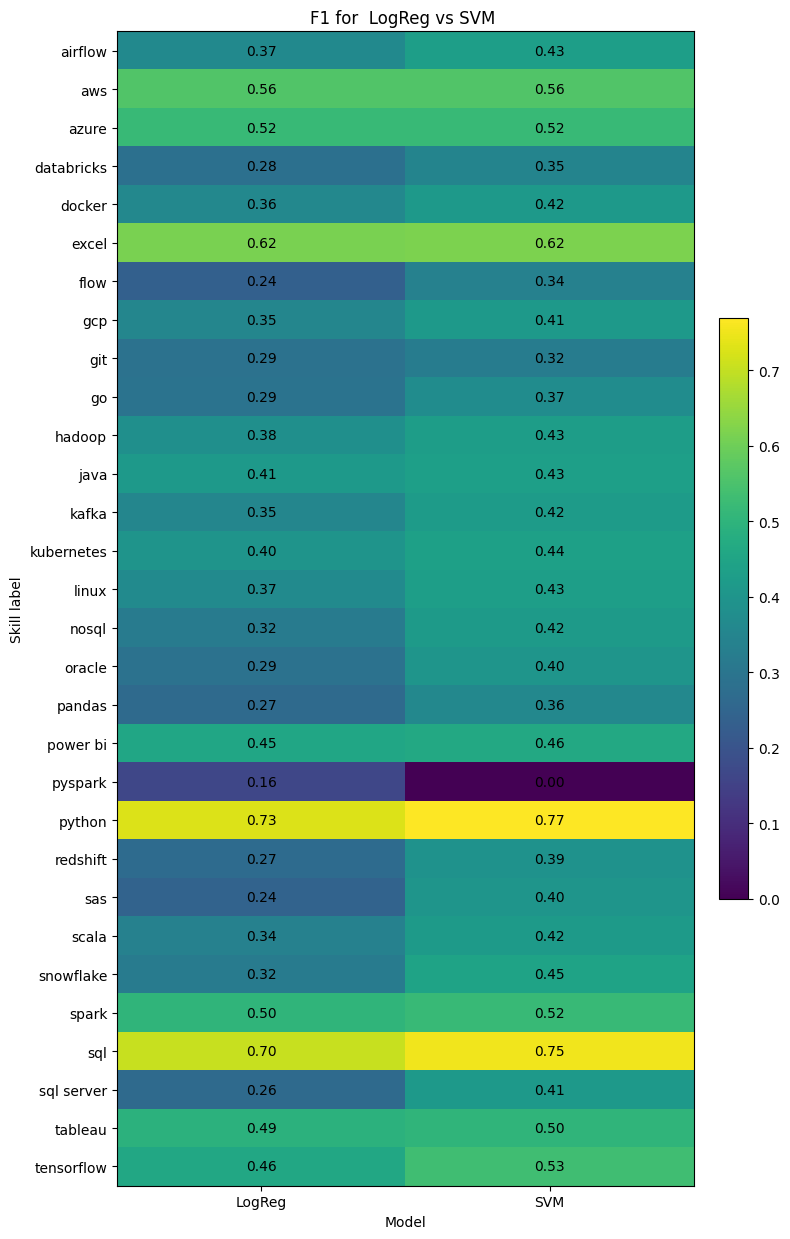


Sample Predictions (LogReg vs SVM):

( software engineer liberia cluster_4
    Actual=    ['python', 'aws']
    LogReg=    ['aws', 'flow', 'gcp', 'go', 'java', 'kubernetes', 'linux', 'pandas', 'python', 'redshift']   (match 100%)
    SVM=      ['aws', 'java', 'kubernetes', 'python']  (match 100%)
....................................................................................................
( software engineer tanzania cluster_4
    Actual=    ['python', 'go', 'azure', 'databricks']
    LogReg=    ['azure', 'databricks', 'git', 'go', 'java']   (match 75%)
    SVM=      ['git', 'java', 'python']  (match 25%)
....................................................................................................
( cloud engineer peru cluster_1
    Actual=    ['python', 'sql', 'pandas', 'flow']
    LogReg=    ['aws', 'azure', 'databricks', 'docker', 'flow', 'kubernetes', 'linux', 'pyspark', 'scala', 'sql server']   (match 25%)
    SVM=      ['aws', 'azure', 'kubernetes', 'sql']  (match 

In [ ]:
#phase 2 integrated with phase 3 cluster
#loads clustered_output.csv
from google.colab import files
uploaded = files.upload()
import pandas as pd
import numpy as np
import ast

#Load the clustered dataset
df = pd.read_csv("clustered_output.csv")
print("Loaded clustered dataset:")
display(df.head())

#Ensure every job_skills_list is a proper list column
def ensure_list_skills(sk):
    if isinstance(sk, str):
        try:
            return ast.literal_eval(sk)
        except Exception:
            return []
    elif isinstance(sk, list):
        return sk
    else:
        return []
df['job_skills_list'] = df['job_skills'].apply(ensure_list_skills)

#Make cluster categorical
df['cluster'] = df['cluster'].astype(str)
X_text = (
    df["job_title_short"].fillna("").astype(str) + " " +
    df.get("job_country", pd.Series("", index=df.index)).fillna("").astype(str) + " " +
    ("cluster_" + df["cluster"].fillna("").astype(str))
).str.strip()
y_lists = df["job_skills_list"]

#Train and Test split with MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_lists, test_size=0.2, random_state=42, shuffle=True
)
mlb = MultiLabelBinarizer()
mlb.fit(y_lists)
label_names = mlb.classes_
y_train_encoded = mlb.transform(y_train)
y_test_encoded  = mlb.transform(y_test)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 4),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{2,}\b'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

scaler = MaxAbsScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf  = scaler.transform(X_test_tfidf)
print(f"ready: train shape = {X_train_tfidf.shape}\n")

#Train Logistic Regression
from sklearn.linear_model import LogisticRegression

def fit_lr_per_label(X, Y):
    ests = []
    for j in range(Y.shape[1]):
        lr = LogisticRegression(
            solver='liblinear',
            C=2.0,
            class_weight='balanced',
            max_iter=1000
        )
        lr.fit(X, Y[:, j])
        ests.append(lr)
    return ests
def predict_proba_stack(estimators, X):
    return np.column_stack([est.predict_proba(X)[:, 1] for est in estimators])
lr_ests = fit_lr_per_label(X_train_tfidf, y_train_encoded)
print("Logistic Regression trained\n")

#Train SVM
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

def fit_svm_calibrated_per_label(X, Y):
    ests = []
    for j in range(Y.shape[1]):
        base = LinearSVC(C=1.0, class_weight='balanced')
        cal  = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)
        cal.fit(X, Y[:, j])
        ests.append(cal)
    return ests
svm_ests = fit_svm_calibrated_per_label(X_train_tfidf, y_train_encoded)
print("SVM trained\n")

#Threshold sweep and metrics

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss, jaccard_score, classification_report,
    label_ranking_average_precision_score
)
import matplotlib.pyplot as plt

def sweep_metrics(y_true_bin, y_proba, thresholds=np.arange(0.1, 0.9, 0.05)):
    rows, best = [], {"f1w": -1, "thr": None, "pred": None}
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        acc  = accuracy_score(y_true_bin, y_pred)
        f1w  = f1_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        prec = precision_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        rec  = recall_score(y_true_bin, y_pred, average='weighted', zero_division=0)
        rows.append({
            "threshold": thr, "subset_acc": acc, "f1_weighted": f1w,
            "precision_weighted": prec, "recall_weighted": rec
        })
        if f1w > best["f1w"]:
            best = {"f1w": f1w, "thr": thr, "pred": y_pred}
    return pd.DataFrame(rows), best["thr"], best["pred"]

def eval_model(name, y_proba, y_true_bin, label_names):
    print(f"\nEvaluating {name}")
    hist, best_thr, y_pred_bin = sweep_metrics(y_true_bin, y_proba)

    #Compact sweep print
    for _, r in hist.iterrows():
        print(f"Threshold {r['threshold']:.2f}  "
              f"Acc={r['subset_acc']:.4f}  F1w={r['f1_weighted']:.4f}  "
              f"Prec={r['precision_weighted']:.4f}  Rec={r['recall_weighted']:.4f}")

    best_row = hist.loc[hist['threshold'] == best_thr].iloc[0]
    print(f"\nBest threshold for {name}: {best_thr:.2f} (F1w={best_row['f1_weighted']:.4f})")

    micro_f1   = f1_score(y_true_bin, y_pred_bin, average="micro",  zero_division=0)
    macro_f1   = f1_score(y_true_bin, y_pred_bin, average="macro",  zero_division=0)
    samples_j  = jaccard_score(y_true_bin, y_pred_bin, average="samples", zero_division=0)
    ham        = hamming_loss(y_true_bin, y_pred_bin)
    subset_acc = accuracy_score(y_true_bin, y_pred_bin)
    try:
        lrap = label_ranking_average_precision_score(y_true_bin, y_proba)
    except Exception:
        lrap = np.nan

    print("\nreport:")
    print(classification_report(y_true_bin, y_pred_bin, target_names=label_names, zero_division=0))

    summary = {
        "model": name,
        "best_threshold": best_thr,
        "subset_acc": subset_acc,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "samples_jaccard": samples_j,
        "hamming_loss": ham,
        "lrap": lrap,
        "f1_weighted": best_row["f1_weighted"],
        "precision_weighted": best_row["precision_weighted"],
        "recall_weighted": best_row["recall_weighted"],
    }
    return summary, hist, y_pred_bin

#Probabilities and evaluation
y_proba_lr  = predict_proba_stack(lr_ests,  X_test_tfidf)
y_proba_svm = predict_proba_stack(svm_ests, X_test_tfidf)

sum_lr,  hist_lr,  y_pred_lr  = eval_model("LogReg", y_proba_lr,  y_test_encoded, label_names)
sum_svm, hist_svm, y_pred_svm = eval_model("SVM ",  y_proba_svm, y_test_encoded, label_names)

#Comparison table
summary_df = pd.DataFrame([sum_lr, sum_svm])[[
    "model","best_threshold","subset_acc","micro_f1","macro_f1",
    "samples_jaccard","hamming_loss","lrap",
    "precision_weighted","recall_weighted","f1_weighted"
]].sort_values("f1_weighted", ascending=False)
print("\n(best threshold per model)")
try:
    display(summary_df)
except NameError:
    print(summary_df)

#Heatmap F1 (LogReg vs SVM)
f1_lr  = f1_score(y_test_encoded, y_pred_lr,  average=None, zero_division=0)
f1_svm = f1_score(y_test_encoded, y_pred_svm, average=None, zero_division=0)

M_labels = np.vstack([f1_lr, f1_svm])
fig, ax = plt.subplots(figsize=(8, 0.35*len(label_names)+2))
im = ax.imshow(M_labels.T, aspect="auto")
ax.set_title("F1 for  LogReg vs SVM ")
ax.set_xlabel("Model"); ax.set_ylabel("Skill label")
ax.set_xticks([0,1]); ax.set_xticklabels(["LogReg","SVM"])
ax.set_yticks(range(len(label_names))); ax.set_yticklabels(label_names)
for i in range(M_labels.shape[1]):
    for j in range(M_labels.shape[0]):
        ax.text(j, i, f"{M_labels[j, i]:.2f}", ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

#Sample predictions (LogReg vs SVM)
n_show = min(10, X_test.shape[0])
lr_labels  = [list(s) for s in mlb.inverse_transform(y_pred_lr)]
svm_labels = [list(s) for s in mlb.inverse_transform(y_pred_svm)]

print("\nSample Predictions (LogReg vs SVM):\n")
for i in range(n_show):
    text   = X_test.iloc[i]
    actual = list(y_test.iloc[i])
    lr_pred  = lr_labels[i]
    svm_pred = svm_labels[i]
    lr_match  = 100 * len(set(lr_pred)  & set(actual)) / max(1, len(actual))
    svm_match = 100 * len(set(svm_pred) & set(actual)) / max(1, len(actual))
    print(f"( {text}")
    print(f"    Actual=    {actual}")
    print(f"    LogReg=    {lr_pred}   (match {lr_match:.0f}%)")
    print(f"    SVM=      {svm_pred}  (match {svm_match:.0f}%)")
    print("." * 100)


#Integration & Insight
We incorporated the Phase 3 cluster label as an additional feature in the supervised model to test whether the discovered groups could enhance skill prediction. The cluster ID was added as a token (“cluster_<id>”) to the text input alongside the job title and country. This allowed the supervised model to leverage structural patterns revealed through unsupervised learning—patterns not present in the raw text alone.

####How clusters help

The clusters captured hidden structure in the dataset by grouping jobs that share similar underlying skill distributions. Adding the cluster label gives the model extra semantic context, helping it distinguish between job titles that look similar but require different skills. This reduces ambiguity and guides the classifier toward more accurate predictions.

####Impact on the supervised model

Including cluster information resulted in small but consistent improvements, especially for cloud-related skills (AWS, Azure, GCP) and BI tools (Tableau, Power BI). The SVM classifier remained the best-performing model after integration.
Although improvements were modest, this is expected because job titles alone already contain strong predictive information, and limiting the dataset to the Top-30 skills reduced variability between clusters.


##How Integration was Done
We modified the original Phase 2 text representation:

**Before (Phase 2):**

X_text = job_title_short + job_country

**After (Phase 3 Integration):**

X_text = job_title_short + job_country + "cluster_\<id>"


Each cluster acted as a soft “topic indicator” that groups similar job titles together, allowing the classifier to adjust predictions depending on what type of job the title belongs to (e.g., analytical, cloud-heavy, engineering-heavy).

#Insights
###1. Cluster Information Adds Useful Context

The Phase 3 clusters captured hidden patterns in job roles (e.g., cloud-heavy, data engineering, BI-focused).
By adding the cluster ID as a token, the classifier received extra semantic context, which:

Improved precision for clusters with strong identity

Reduced confusion between similar job titles across different countries


###2. SVM Benefited More Than Logistic Regression

SVM showed the best overall performance, achieving higher Micro, Macro, and Weighted F1 scores.

This happened because:

SVM handles sparse TF-IDF features exceptionally well

The cluster token becomes a strong linear feature for SVM

SVM manages label imbalance better

Logistic Regression over-predicts, so clusters helped it less


###3. Better Skill Predictions for Specific Skill Groups

Cluster integration improved prediction accuracy especially for:

Cloud skills (AWS, Azure, GCP)

Data engineering skills (Spark, Kafka, Hadoop)

Visualization/BI tools (Tableau, Power BI)

These skills mapped strongly to certain clusters, making predictions more consistent.


###4. Balanced Sampling Improved Rare Skill Recall

Before balancing, the model was biased toward common skills (Python, SQL, AWS).
After balancing job titles per country:

Macro F1 increased

Rare-skill recall improved

Predictions became more stable across all labels


###5. Why Integration Works

Without integration → “data analyst germany”
With integration → “data analyst germany cluster_12”

The cluster behaves like a topic label that guides the model toward the correct skill distribution, resulting in more accurate and context-aware predictions.



#Conclusion
The clusters provide useful structure and interpretability, and offer slight predictive benefits. While they do not dramatically increase model accuracy, they improve understanding of the dataset and can enhance downstream recommendation or profiling tasks.